In [1]:
# import better_exceptions
from scikit_quri.qnn.regressor import QNNRegressor
import numpy as np
from numpy.random import default_rng

from quri_parts.core.operator import Operator, pauli_label
from quri_parts.core.estimator.gradient import create_numerical_gradient_estimator
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_concurrent_parametric_estimator,
    create_qulacs_vector_concurrent_estimator,
)
from quri_parts.algo.optimizer import Adam
from scikit_quri.circuit.pre_defined import create_qcl_ansatz


def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi * x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    # return np.array(x_train), np.array(y_train)
    return np.array(x_train).flatten(), np.array(y_train)


x_train, y_train = generate_noisy_sine(-1.0, 1.0, 80)
x_test, y_test = generate_noisy_sine(-1.0, 1.0, 80)

In [2]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt

n_qubits = 5
depth = 6
n_outputs = 1
parametric_circuit = create_qcl_ansatz(n_qubits, depth, 0.5, 0)

draw_circuit(parametric_circuit.circuit)

estimator = create_qulacs_vector_concurrent_estimator()
gradient_estimator = create_numerical_gradient_estimator(
    create_qulacs_vector_concurrent_parametric_estimator(), delta=1e-10
)
adam = Adam()

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|10 |---|11 |---|12 |---|13 |---|26 |---|27 |---|28 |---|29 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|14 |---|15 |---|16 |---|   |---|30 |---|31 |---|32 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|17 |---|18 |---|19 |---|   |---|33 |---|34 |---|35 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [3]:
init_params = 2 * np.pi * np.random.rand(parametric_circuit.learning_params_count)

In [4]:
qnn = QNNRegressor(n_qubits, parametric_circuit, estimator, gradient_estimator, adam)

qnn.fit(x_train, y_train, maxiter=30)

init_params=array([0.89882651, 3.44343701, 4.33959656, 4.51809347, 0.60712333,
       0.38274356, 0.31513836, 4.92962224, 3.22983588, 4.65059944,
       1.65982456, 0.69269355, 3.55512151, 5.77900608, 2.40437008,
       3.60322662, 5.51361656, 0.24980597, 2.72992944, 5.48338721,
       2.10244211, 1.78021283, 0.86169519, 0.83632952, 3.70958844,
       4.83424477, 5.00970796, 2.28060426, 4.81742329, 3.830731  ,
       3.50380798, 4.9639592 , 5.30714045, 2.29449842, 1.8105474 ,
       3.71190583, 0.95439576, 5.82517657, 4.299903  , 4.7691804 ,
       3.67517928, 0.67554989, 2.80463186, 1.64145405, 4.40469602,
       2.46937287, 0.91182651, 4.88728333, 1.27887425, 4.0975892 ,
       3.0014668 , 0.60659633, 4.86790809, 3.82081355, 1.36039939,
       2.00913776, 5.53580609, 4.8075766 , 4.75504669, 0.95418207,
       5.24224855, 3.38083282, 4.99554858, 5.80023979, 1.81127592,
       0.12226941, 4.51554357, 1.30314322, 1.56559946, 2.29823764,
       3.79239149, 0.52400853, 4.049228  , 5.80783

loss=0.007345039320561264


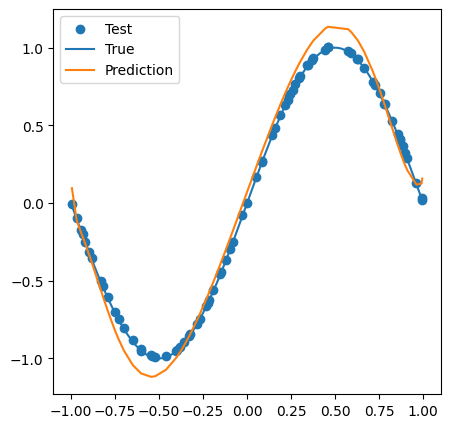

In [5]:
y_pred = qnn.predict(x_test)
y_test = y_test.reshape(-1, 1)
plt.figure(figsize=(5, 5))

plt.scatter(np.sort(x_test.flatten()), y_test[np.argsort(x_test.flatten())], label="Test")

x_true = np.linspace(-1, 1, 100)
y_true = np.sin(np.pi * x_true)
plt.plot(x_true, y_true, label="True")
plt.plot(np.sort(x_test.flatten()), y_pred[np.argsort(x_test.flatten())], label="Prediction")
plt.legend()

from sklearn.metrics import mean_squared_error

loss = mean_squared_error(y_test, y_pred)
print(f"{loss=}")
plt.show()